# House Prices Advanced Regression and Analysis

## Shunling Guo, Ph.D.


## This is not only a house price regression problem, but apply to all similar problems sharing the following criterias:


### 1. Only one outcome (observation) feature, could be either categorical or numeric.
### 2. The parameters/features which could affect the outcome are too many to fit human predictable model or function.
### 3. The parameters/features to affect the outcome should be less than the training samples.
### 4. There are a mix of categorical and numeric features.

In [1]:
#-----------------------------------------------------------------------------#
# Load Packages for 
    #data wrangling, modeling, statistical analysis and visualization
#-----------------------------------------------------------------------------#
import pandas as pd
import numpy as np
import math
import seaborn as sns
from IPython import display
from ipywidgets import interact, widgets
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



In [2]:
#-----------------------------------------------------------------------------#
#Data wrangling: Load training data and transform to analyzable format
#-----------------------------------------------------------------------------#
# load data to pandas dataframe
df = pd.read_csv('train.csv', index_col=['Id']) 

# fill NA for both catogorial and numerical data
for col in df.columns:
    if df[col].dtypes == 'object':
        df[col]=df[col].fillna('0') #fill na with 0
    else:
        df[col]=df[col].fillna(0)

# for GrageYrBlt data, fill NA with 0 is not right, fill with maximum value
maxage = df.GarageYrBlt.max()
df.GarageYrBlt = df['GarageYrBlt'].replace(0, maxage)
        
# transform year data to age for cumputation
for col in ['YearBuilt','YearRemodAdd','GarageYrBlt']:
    df[col] = df['YrSold'] - df[col]

# change SalePrice to fold of 1k
df['SalePrice'] = df.SalePrice / 1000

# dispaly data shape
df.shape   

(1460, 80)

In [ ]:
# Data Exploration: selling price change during years with Zoning info

def plotyear(year):
    data = df[df.YrSold == year].sort_values(['MSZoning'],ascending=False)
    
    ax = sns.lmplot('GrLivArea','SalePrice',data, hue='MSZoning',height=5,aspect=3)
    
    plt.xlabel('GrLivArea')
    plt.ylabel('SalePrice')
    plt.title(year,fontsize=20)
    ax.set(ylim=(0,700))
    ax.set(xlim=(0,4000))

In [55]:
# Data Exploration: selling price change during years with Zoning info
interact(plotyear,year=widgets.IntSlider(min=2006,max=2010,step=1))
print('RM: Residential Medium Density,',
     'RL: Residential Low Density,',
     'RH: Residential High Density,',
     'FV: Floating Village Residential,',
     'C: Commercial.')

interactive(children=(IntSlider(value=2006, description='year', max=2010, min=2006), Output()), _dom_classes=(…

RM: Residential Medium Density, RL: Residential Low Density, RH: Residential High Density, FV: Floating Village Residential, C: Commercial.


In [56]:
# Question1: Is there a pattern for neighborhood in terms of house quality and price?
import matplotlib.cm as cm
import matplotlib.colors as colors

def plotyear_2(year):
    #select data according to year
    data = df[df.YrSold == year].sort_values(['LotArea','SalePrice'],ascending=False)
    #size info from LotArea
    area = data.LotArea * 0.01
    #color infor from neighboorhood
    neighborhood = df.Neighborhood.unique()
    
    explain_neighborhood = {
      'Blmngtn':'Bloomington Heights',
      'Blueste':'Bluestem',
      'BrDale':'Briardale',
      'BrkSide':'Brookside',
       'ClearCr':'Clear Creek',
       'CollgCr':'College Creek',
       'Crawfor':'Crawford',
       'Edwards':'Edwards',
       'Gilbert':'Gilbert',
       'IDOTRR':'Iowa DOT and Rail Road',
       'MeadowV':'Meadow Village',
       'Mitchel':'Mitchell',
       'NAmes':'North Ames',
       'NoRidge':'Northridge',
       'NPkVill':'Northpark Villa',
       'NridgHt':'Northridge Heights',
       'NWAmes':'Northwest Ames',
       'OldTown':'Old Town',
       'SWISU':'South & West of Iowa State University',
       'Sawyer':'Sawyer',
       'SawyerW':'Sawyer West',
       'Somerst':'Somerset',
       'StoneBr':'Stone Brook',
       'Timber':'Timberland',
       'Veenker':'Veenker'
    }
    colormap = cm.gist_rainbow
    colorlist = [colors.rgb2hex(colormap(i)) for i in np.linspace(0, 1, len(neighborhood))]
    color_label = dict(zip(neighborhood,colorlist))
    color = data.Neighborhood.map(color_label)
    
    #Plot OverallQual and SalePrice relationship
    ax = data.plot.scatter('SalePrice','OverallQual',
                     s=area,c=color,
                     linewidths=1,edgecolors='k',
                     figsize=(15,6))
    ax.set(ylim=(0,12))
    ax.set(xlim=(0,700))
    plt.xlabel('SalePrice (k)',fontsize=18)
    plt.ylabel('OverallQual',fontsize=18)
    plt.title(year,fontsize=20)
    
    #plot legend
    for i in range(len(colorlist)):
        plt.scatter(0,0,label=explain_neighborhood[neighborhood[i]],
                    color=color_label[neighborhood[i]],s=50,linewidths=1,edgecolors='k')
    plt.legend(ncol=1,bbox_to_anchor=(1, 1),loc=2)
    
    plt.savefig('plotyear_2_'+str(year)+'.png')


In [53]:
interact(plotyear_2,year=widgets.IntSlider(min=2006,max=2010,step=1))

interactive(children=(IntSlider(value=2006, description='year', max=2010, min=2006), Output()), _dom_classes=(…

<function __main__.plotyear_2(year)>

# ----------------------------------------------------------------------------- #
## Q: How bedroom number contributes to Sale Price?
# ----------------------------------------------------------------------------- #

In [3]:

# Step-1: Plot the ralationship of SalePrice with Living Area with BedRoom information

def plot_bedroom(df):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    colors = dict(zip(df.BedroomAbvGr.unique(),np.array(['C'+str(s) for s in range(len(df.BedroomAbvGr.unique()))])))
    plt.scatter(df.GrLivArea, df.SalePrice,
                s=df.BedroomAbvGr*20,
                c=df.BedroomAbvGr.replace(colors),alpha=0.5)

    for i in range(len(df.BedroomAbvGr.unique())):
        plt.scatter(0,0,
                    c = colors[df.BedroomAbvGr.unique()[i]], alpha=0.5,
                    label=df.BedroomAbvGr.unique()[i])
    ax.set_xlim(left=100)
    ax.set_ylim(df.SalePrice.min()-3,df.SalePrice.max()+3)
    plt.legend(title='Bedroom No.')
    plt.xlabel('GrLivArea')
    plt.ylabel('SalePrice (k)')
    plt.show()

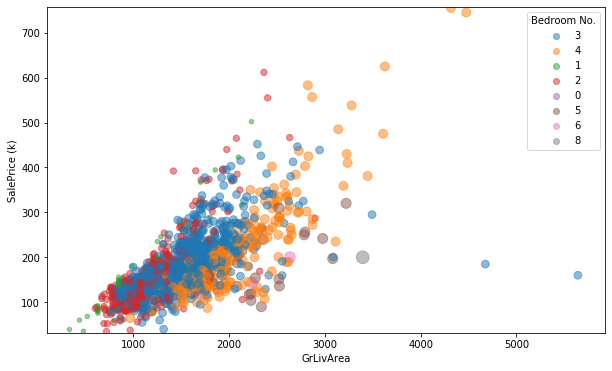

In [13]:
# Step-1: Plot the ralationship of SalePrice with Living Area with BedRoom information
plot_bedroom(df)

In [4]:
def plot_mean_sd_BR(df):
    mean = df.groupby('BedroomAbvGr').SalePrice.mean()
    sd = df.groupby('BedroomAbvGr').SalePrice.std()
    mean.plot(kind='bar', fill=False, linewidth = 1, color='k', yerr=sd)
    plt.ylabel('Sale Price (k)')


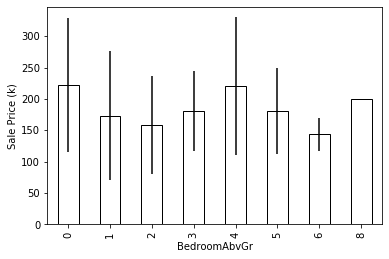

In [5]:
plot_mean_sd_BR(df)

(675, 80)

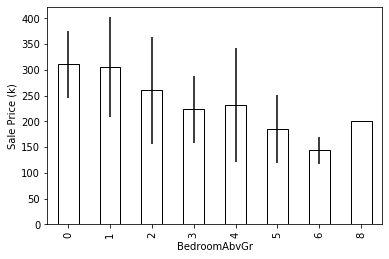

In [6]:
df1500 = df[df.GrLivArea > 1500]
plot_mean_sd_BR(df1500)
df1500.shape

In [7]:
# ANOVA analysis with post tukey hsd pairwise comparasion
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

br_stats = ols('SalePrice ~ BedroomAbvGr', data=df1500).fit()
anova = sm.stats.anova_lm(br_stats, typ=2)
print(anova)

                    sum_sq     df          F    PR(>F)
BedroomAbvGr  1.416258e+05    1.0  19.308933  0.000013
Residual      4.936273e+06  673.0        NaN       NaN


In [18]:

print(pairwise_tukeyhsd(df1500.SalePrice, df1500.BedroomAbvGr, alpha=0.025))

  Multiple Comparison of Means - Tukey HSD, FWER=0.03   
group1 group2  meandiff p-adj    lower    upper   reject
--------------------------------------------------------
     0      1   -5.4633    0.9 -183.3537  172.427  False
     0      2   -50.298    0.9 -214.0949 113.4989  False
     0      3  -86.8252 0.6258 -247.8204    74.17  False
     0      4  -79.3405 0.7199 -240.9431   82.262  False
     0      5 -124.5233 0.2594 -296.4776  47.4309  False
     0      6 -166.5543 0.0873 -358.2071  25.0984  False
     0      8 -110.3333    0.9 -431.0297  210.363  False
     1      2  -44.8347 0.6362 -128.8069  39.1375  False
     1      3  -81.3619 0.0167 -159.7286  -2.9951   True
     1      4  -73.8772 0.0511 -153.4842   5.7298  False
     1      5   -119.06 0.0023 -218.0053 -20.1147   True
     1      6  -161.091 0.0015 -291.2934 -30.8886   True
     1      8   -104.87    0.9 -393.0853 183.3453  False
     2      3  -36.5272 0.0242  -72.9388  -0.1156   True
     2      4  -29.0425  0.227 

In [8]:
# choose the best model according to random2_search_mse in First model
import xgboost as xgb
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15000000000000002,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
             n_estimators=150, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.6500000000000001, verbosity=1)

In [9]:
# Training model
y = df.SalePrice
X = df.drop('SalePrice',axis=1)

le = LabelEncoder()
X = X.apply(lambda x: le.fit_transform(x))
categorical_mask = (X.dtypes == 'object')
ohe = OneHotEncoder(categorical_features=categorical_mask, sparse=False)
X = ohe.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15000000000000002,
             max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
             n_estimators=150, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.6500000000000001, verbosity=1)

In [10]:
# Validate model accuaracy 
y_predict = model.predict(X_test)

from sklearn.metrics import r2_score
r2_score(y_test,y_predict)

0.9015321055854749

In [22]:
# simulation with other features the same value but only assign bedroom numbers randomly.

def simulate_bedroom(df_s):
    n = df_s.shape[0]
    loc = np.random.randint(0,n)
    data = df_s.iloc[loc] # choose a random number to assign all the other attributes
    print(loc, data.GrLivArea)
    
    for col in df_s.columns:
        if col == 'BedroomAbvGr':
            df_s[col] = [np.random.randint(1,8) for i in range(n)] # randomize bedroom numbers
        elif col == 'GrLivArea':
            pass
        else:
            df_s[col] = [data[col] for i in range(n)]
    # add one more criteria to make random bedroom number more realistic
    for i in range(n):
        if df_s.iloc[i]['BedroomAbvGr'] > df_s.iloc[i]['GrLivArea']/300:
            df_s.iloc[i]['BedroomAbvGr']=int(df_s.iloc[i]['GrLivArea']/300)
    
    return df_s

In [11]:
def simulation_price(model,df_new):
    X = df_new
    X = X.apply(lambda x: le.fit_transform(x))
    X = ohe.fit_transform(X)

    df_new['SalePrice'] = model.predict(X)
    
    return df_new.sort_values(by=['BedroomAbvGr'])

17 1524


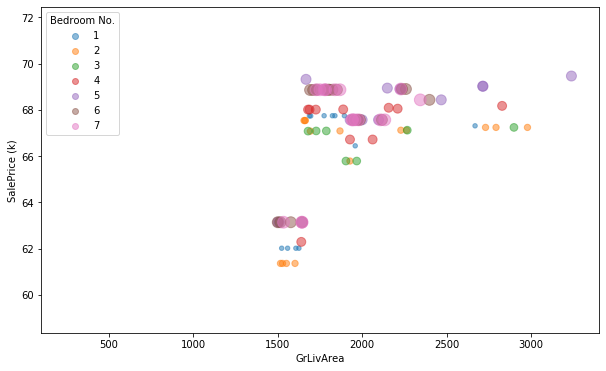

32 1714


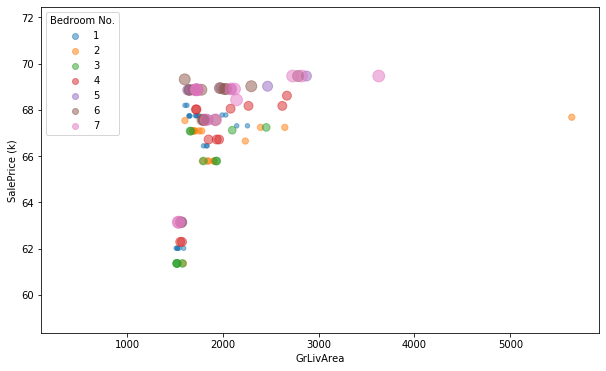

45 2320


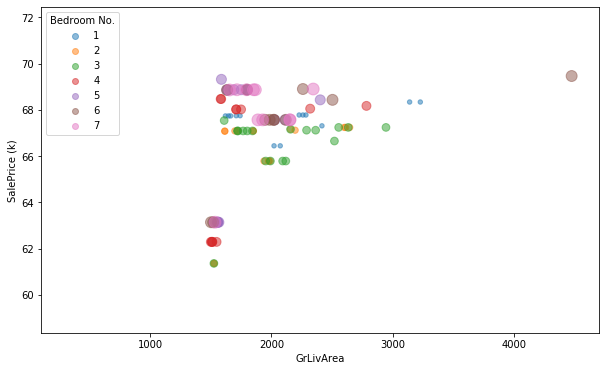

37 2260


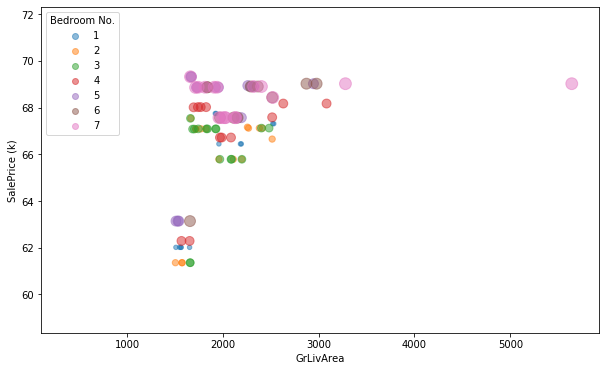

In [39]:
# Simulation
df1 = df1500.drop('SalePrice',axis=1)
dfs = []

for i in range(4):
    
    df_s = df1.sample(n=100,replace=True)
    df_new = simulate_bedroom(df_s)
    df_new = simulation_price(model,df_new)
    dfs.append(df_new)
    plot_bedroom(df_new)

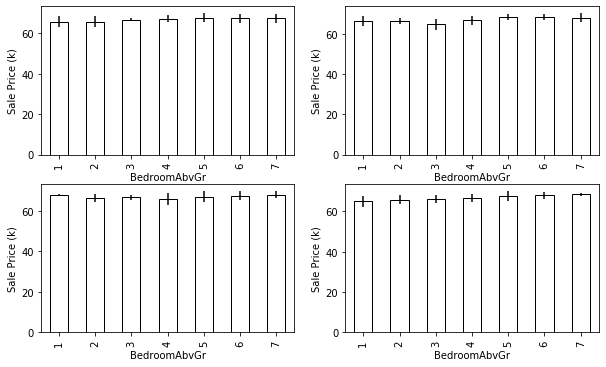

In [43]:
fig = plt.figure(figsize=(10,6))
i = 1
for df in dfs:
    ax = fig.add_subplot(2,2,i)
    i += 1
    plot_mean_sd_BR(df)

In [51]:
br_stats = ols('SalePrice ~ BedroomAbvGr', data=dfs[2]).fit()
anova = sm.stats.anova_lm(br_stats, typ=2)
print(anova)

                  sum_sq    df         F    PR(>F)
BedroomAbvGr    6.147272   1.0  1.425189  0.235433
Residual      422.703633  98.0       NaN       NaN


In [38]:
br_stats = ols('SalePrice ~ BedroomAbvGr', data=df_new).fit()
anova = sm.stats.anova_lm(br_stats, typ=2)
print(anova)

                  sum_sq    df         F    PR(>F)
BedroomAbvGr   16.353510   1.0  3.210291  0.076263
Residual      499.220717  98.0       NaN       NaN


In [27]:
print(pairwise_tukeyhsd(df_new.SalePrice, df_new.BedroomAbvGr, alpha=0.025))

Multiple Comparison of Means - Tukey HSD, FWER=0.03
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     1      2  -2.1247 0.1545 -4.8451 0.5956  False
     1      3  -2.0125 0.2487  -4.851  0.826  False
     1      4  -0.7468    0.9 -3.4671 1.9736  False
     1      5   0.9109    0.9 -1.8832  3.705  False
     1      6   0.7159    0.9 -2.1227 3.5544  False
     1      7   1.1309 0.7831 -1.5306 3.7925  False
     2      3   0.1122    0.9 -2.4076  2.632  False
     2      4   1.3779 0.4955  -1.008 3.7638  False
     2      5   3.0356 0.0023   0.566 5.5053   True
     2      6   2.8406  0.007  0.3208 5.3604   True
     2      7   3.2557  0.001   0.937 5.5743   True
     3      4   1.2657 0.6374 -1.2541 3.7855  False
     3      5   2.9234 0.0072  0.3242 5.5226   True
     3      6   2.7283 0.0186  0.0814 5.3753   True
     3      7   3.1434 0.0013  0.6872 5.5997   True
     4      5   1.6577  0.311  -0.812 4.1273  False
     4      

In [28]:
# simulation with features in list cols the same with original dataset but assign bedroom numbers randomly.

def simulate_bedroom_cols(df_s,cols):
    n = df_s.shape[0]
    loc = np.random.randint(0,n)
    data = df_s.iloc[loc] # choose a random number to assign all the other attributes
    print(loc, data.GrLivArea)
    
    for col in df_s.columns:
        if col == 'BedroomAbvGr':
            df_s[col] = [np.random.randint(1,8) for i in range(n)] # randomize bedroom numbers
        elif col in cols:
            pass
        elif col == 'GrLivArea':
            pass
        else:
            df_s[col] = [data[col] for i in range(n)]
    # add one more criteria to make random bedroom number more realistic
    for i in range(n):
        if df_s.iloc[i]['BedroomAbvGr'] > df_s.iloc[i]['GrLivArea']/300:
            df_s.iloc[i]['BedroomAbvGr']=int(df_s.iloc[i]['GrLivArea']/300)
    
    return df_s

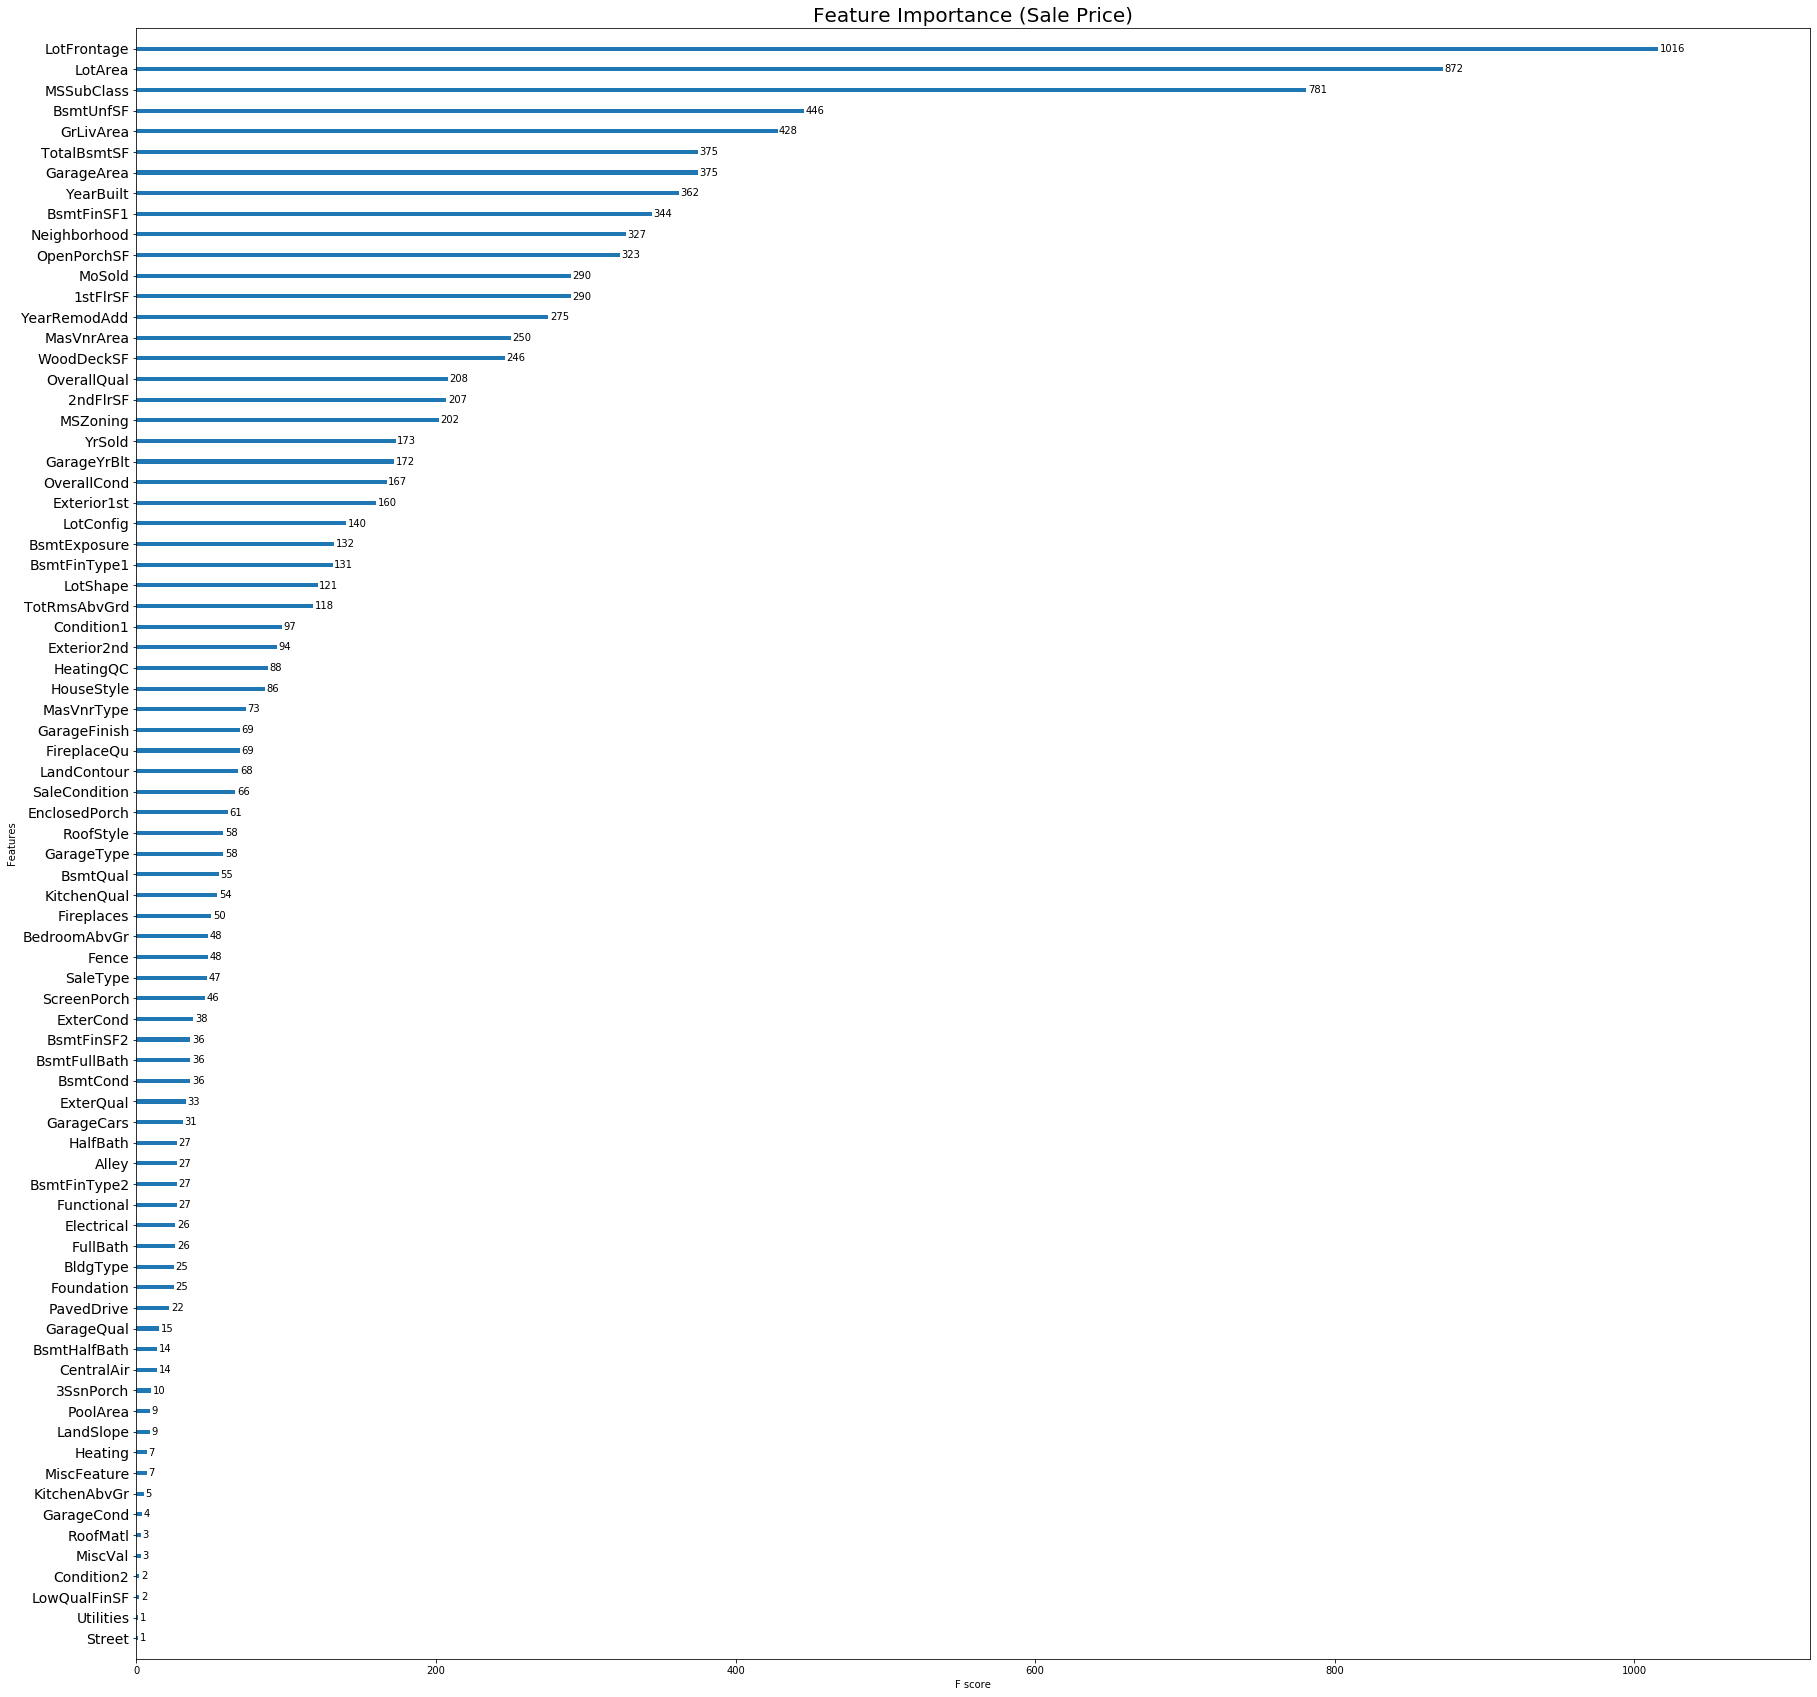

In [29]:
fig1, ax1 = plt.subplots(1,1,figsize=(30,30))
from xgboost import plot_importance
g = plot_importance(model,ax=ax1,grid=False)

oldy = g.yaxis.get_majorticklabels()

features = ['f'+str(x) for x in range(len(df1.columns))]
feature_dict = dict(zip(features,df1.columns))

newy = [str(feature_dict[y._text]) for y in oldy]
g.set_yticklabels(newy, rotation=0, fontsize = 14)

plt.title('Feature Importance (Sale Price)',fontsize=20)

plt.show()

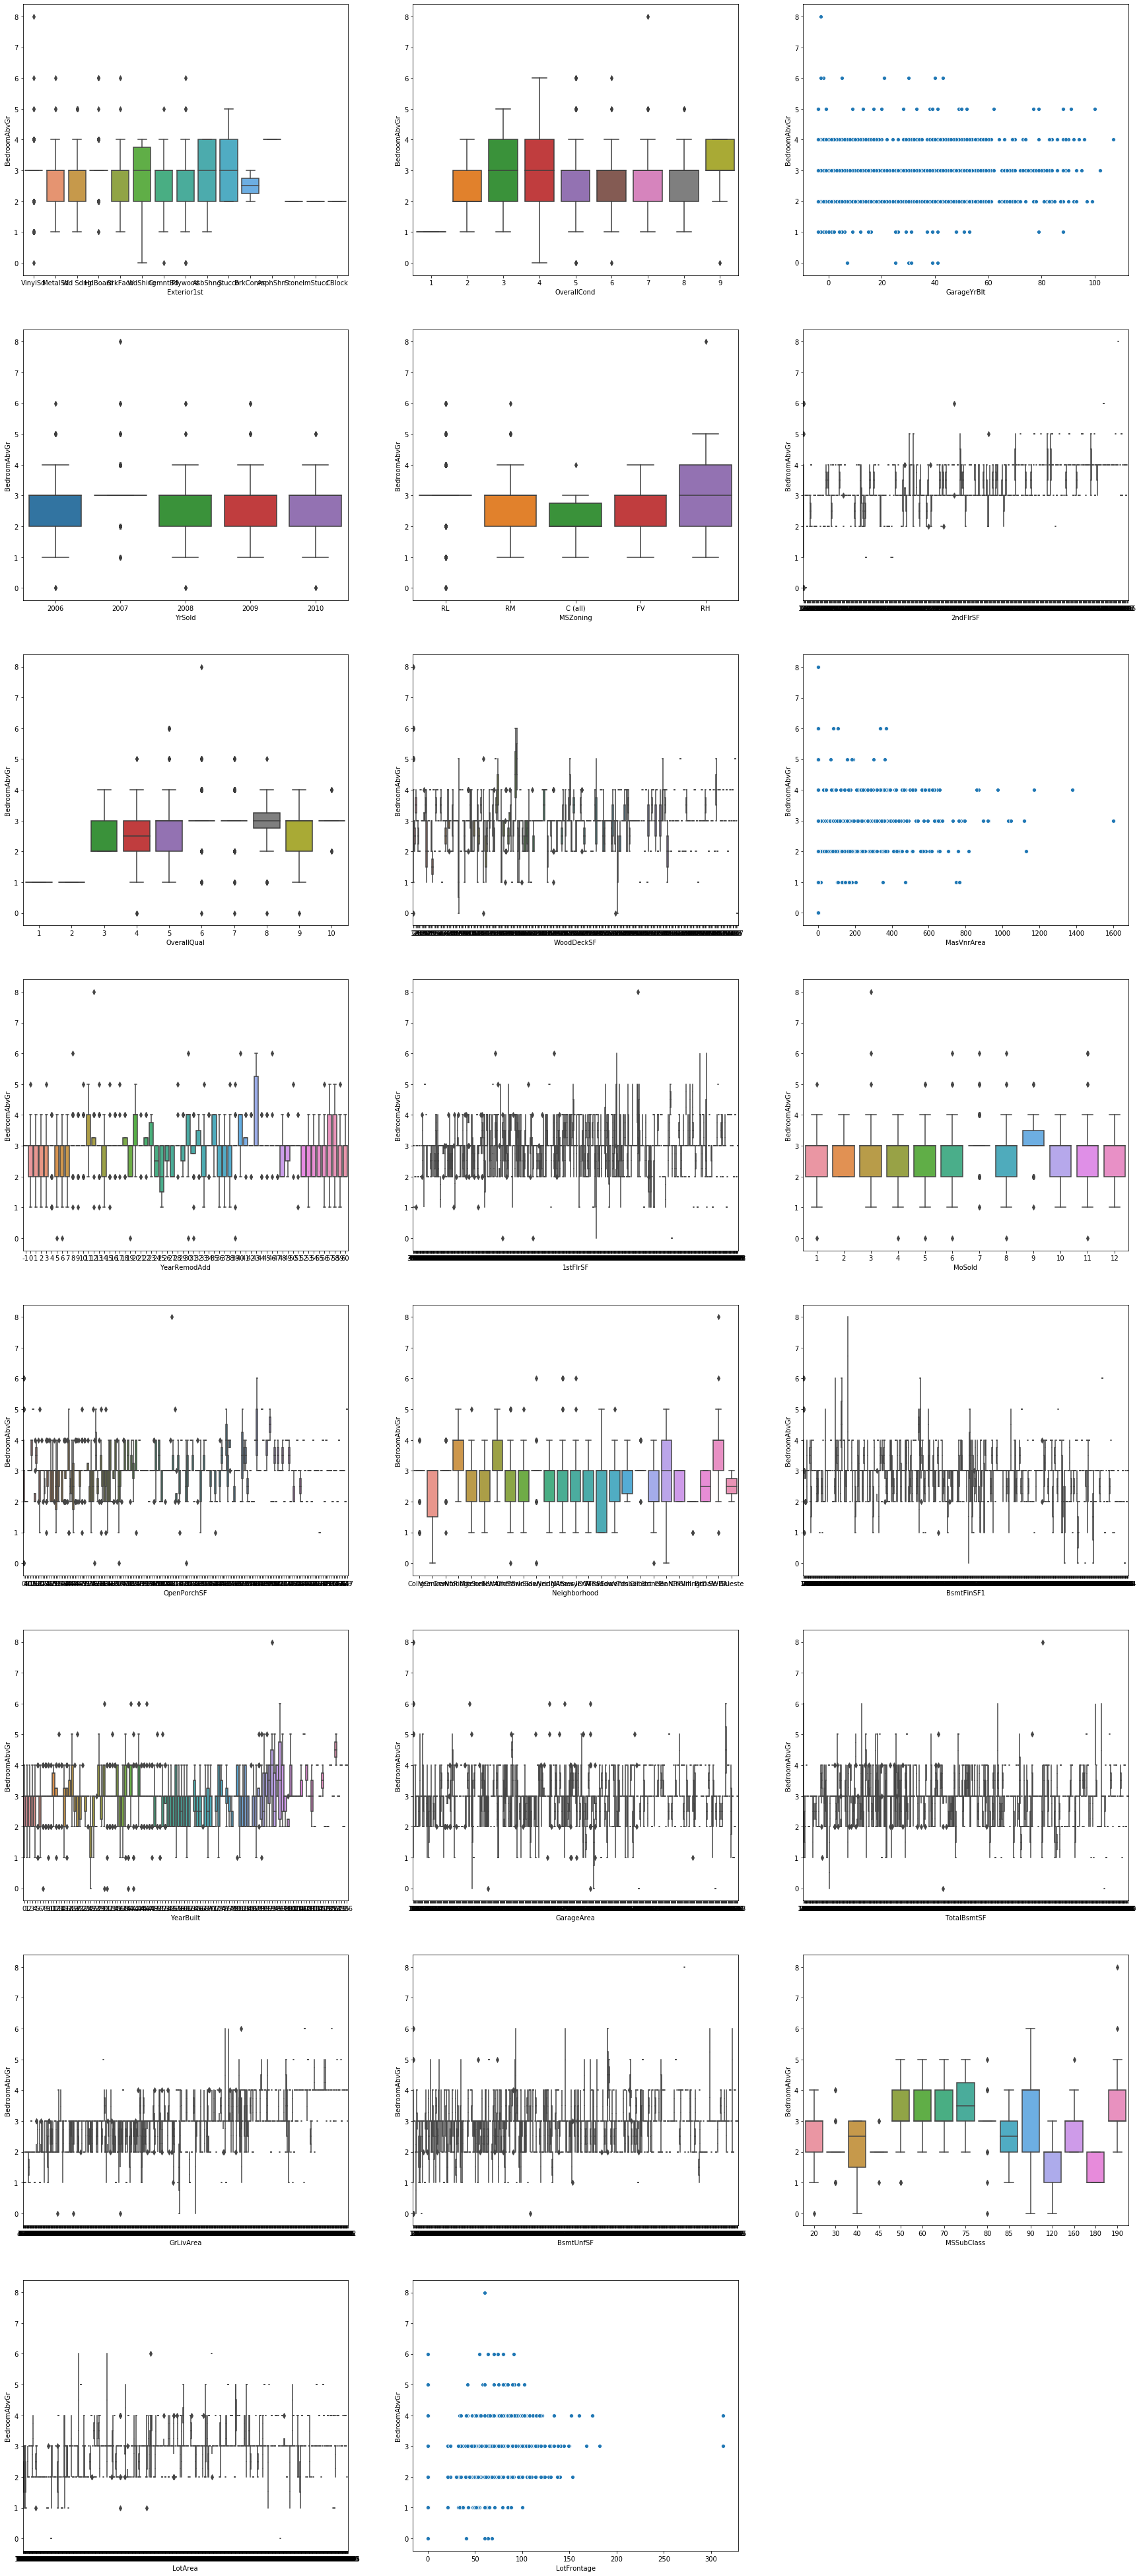

In [30]:
import seaborn as sns
fig = plt.figure(figsize=(30,80))
y_col = 'BedroomAbvGr'
a = 0 #active plot number
for col in newy[55:]:
    a += 1
    ax = fig.add_subplot(9,3,a)
    if df[col].dtype == 'float64':
        sns.scatterplot(x=col, y=y_col, data=df,ax=ax)
    else:
        sns.catplot(x=col, y=y_col,kind='box',data=df,ax=ax)

    ax.set_xlabel(col)
    plt.close(2)

In [31]:
# get cols that are more important than bedroom
cols = newy[34:]

In [15]:
def plot_mean_sd_BR_2(df,name):
    
    mean = df.groupby('BedroomAbvGr').SalePrice.mean()
    sd = df.groupby('BedroomAbvGr').SalePrice.std()
    mean.plot(kind='bar', fill=False, linewidth = 1, color='k', yerr=sd)
    plt.ylabel('Sale Price (k)')
    plt.title(name)

0
8 2093
1
60 2142
2
38 1575
3
13 1768
4
50 1701
5
26 1792
6
1 1774
7
82 2466
8
33 2358
9
62 1624
10
63 2872
11
14 1959
12
40 1756
13
73 1686
14
13 1716
15
20 2320
16
26 1652
17
31 1865
18
14 1863
19
33 3112
20
34 2402
21
70 1572
22
61 1529
23
38 1981
24
83 1557
25
5 1982
26
40 2098
27
53 2520
28
22 1539
29
48 2144
30
37 2090
31
34 1915
32
81 1567
33
61 1718
34
92 1716
35
19 2183
36
20 1848
37
80 2365
38
27 3222
39
15 1850
40
67 2097
41
17 1566
42
22 1654
43
84 3238


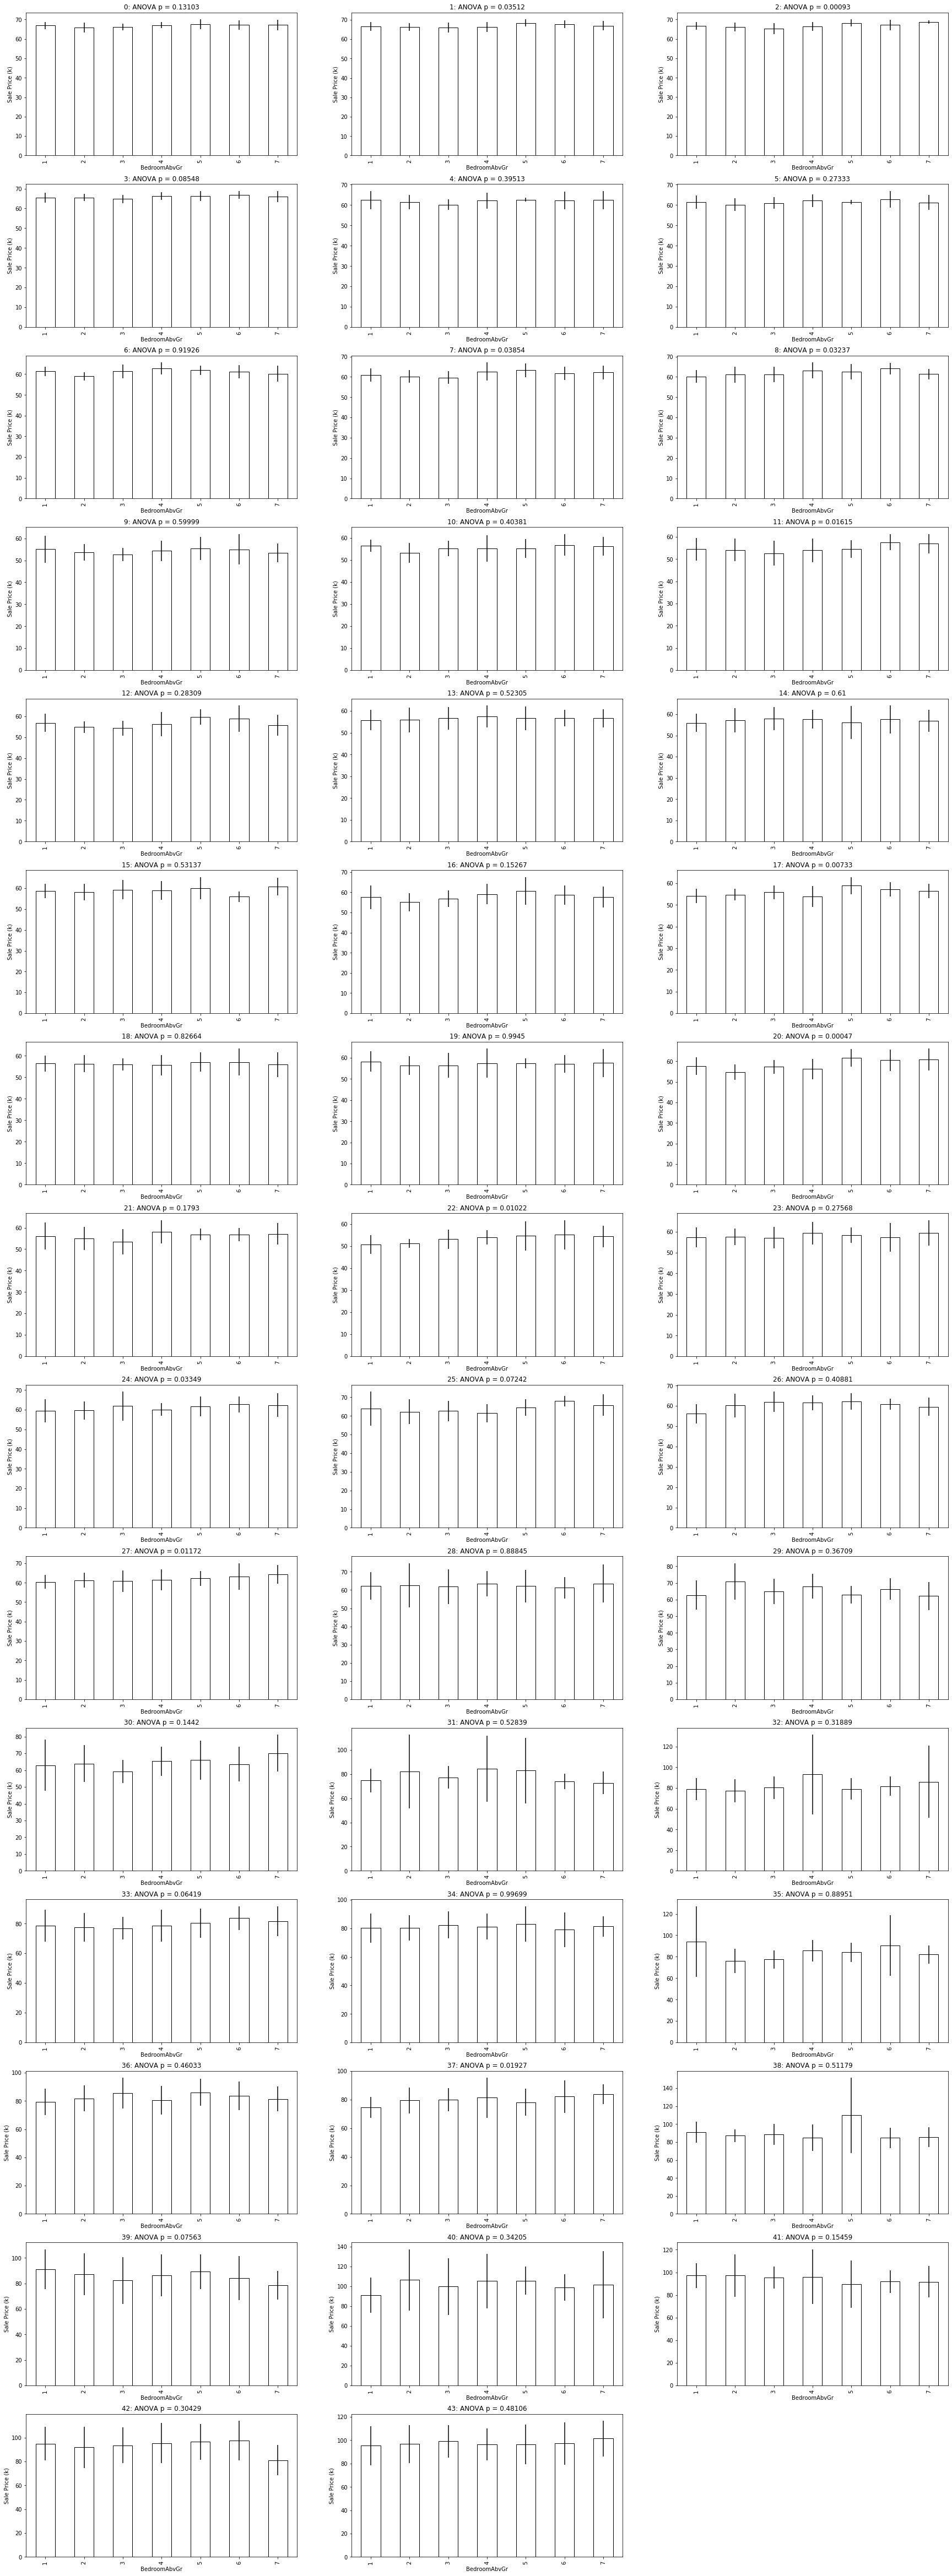

In [33]:
# Simulation
df1 = df1500.drop('SalePrice',axis=1)
fig3 = plt.figure(figsize=(30,85))

for i in range(len(cols)):
    print(i)
    df_s = df1.sample(100,replace=True)
    df_new = simulate_bedroom_cols(df_s,cols[:i]) #adding features from less important to more
    df_new2 = simulation_price(model,df_new)
    
    #Add ANOVA analysis
    new_stats = ols('SalePrice ~ BedroomAbvGr', data=df_new).fit()
    aov = sm.stats.anova_lm(new_stats, typ=2)
    name = str(i)+': ANOVA p = '+str(round(aov['PR(>F)']['BedroomAbvGr'],5) )
    
    #plot mean
    ax = fig3.add_subplot(15,3,i+1)
    plot_mean_sd_BR_2(df_new2,name)


0
63 1734
1
23 2775
2
36 1768
3
69 1700
4
0 2633
5
73 2153
6
37 1922
7
44 1801
8
88 2267
9
41 1978
10
23 1530
11
47 1539
12
97 1601
13
28 1694
14
21 1694
15
54 1872
16
78 1604
17
12 2007
18
19 1511
19
26 1768
20
13 1717
21
92 1707
22
77 1886
23
94 2515
24
61 3279
25
56 1812
26
85 1626
27
37 1526
28
25 1640
29
55 1666
30
14 1803
31
2 1668
32
44 1509
33
71 1852
34
68 1680
35
16 1856
36
53 4676
37
48 2217
38
62 2217
39
90 1869
40
33 1826
41
91 2462
42
27 2596
43
98 1537


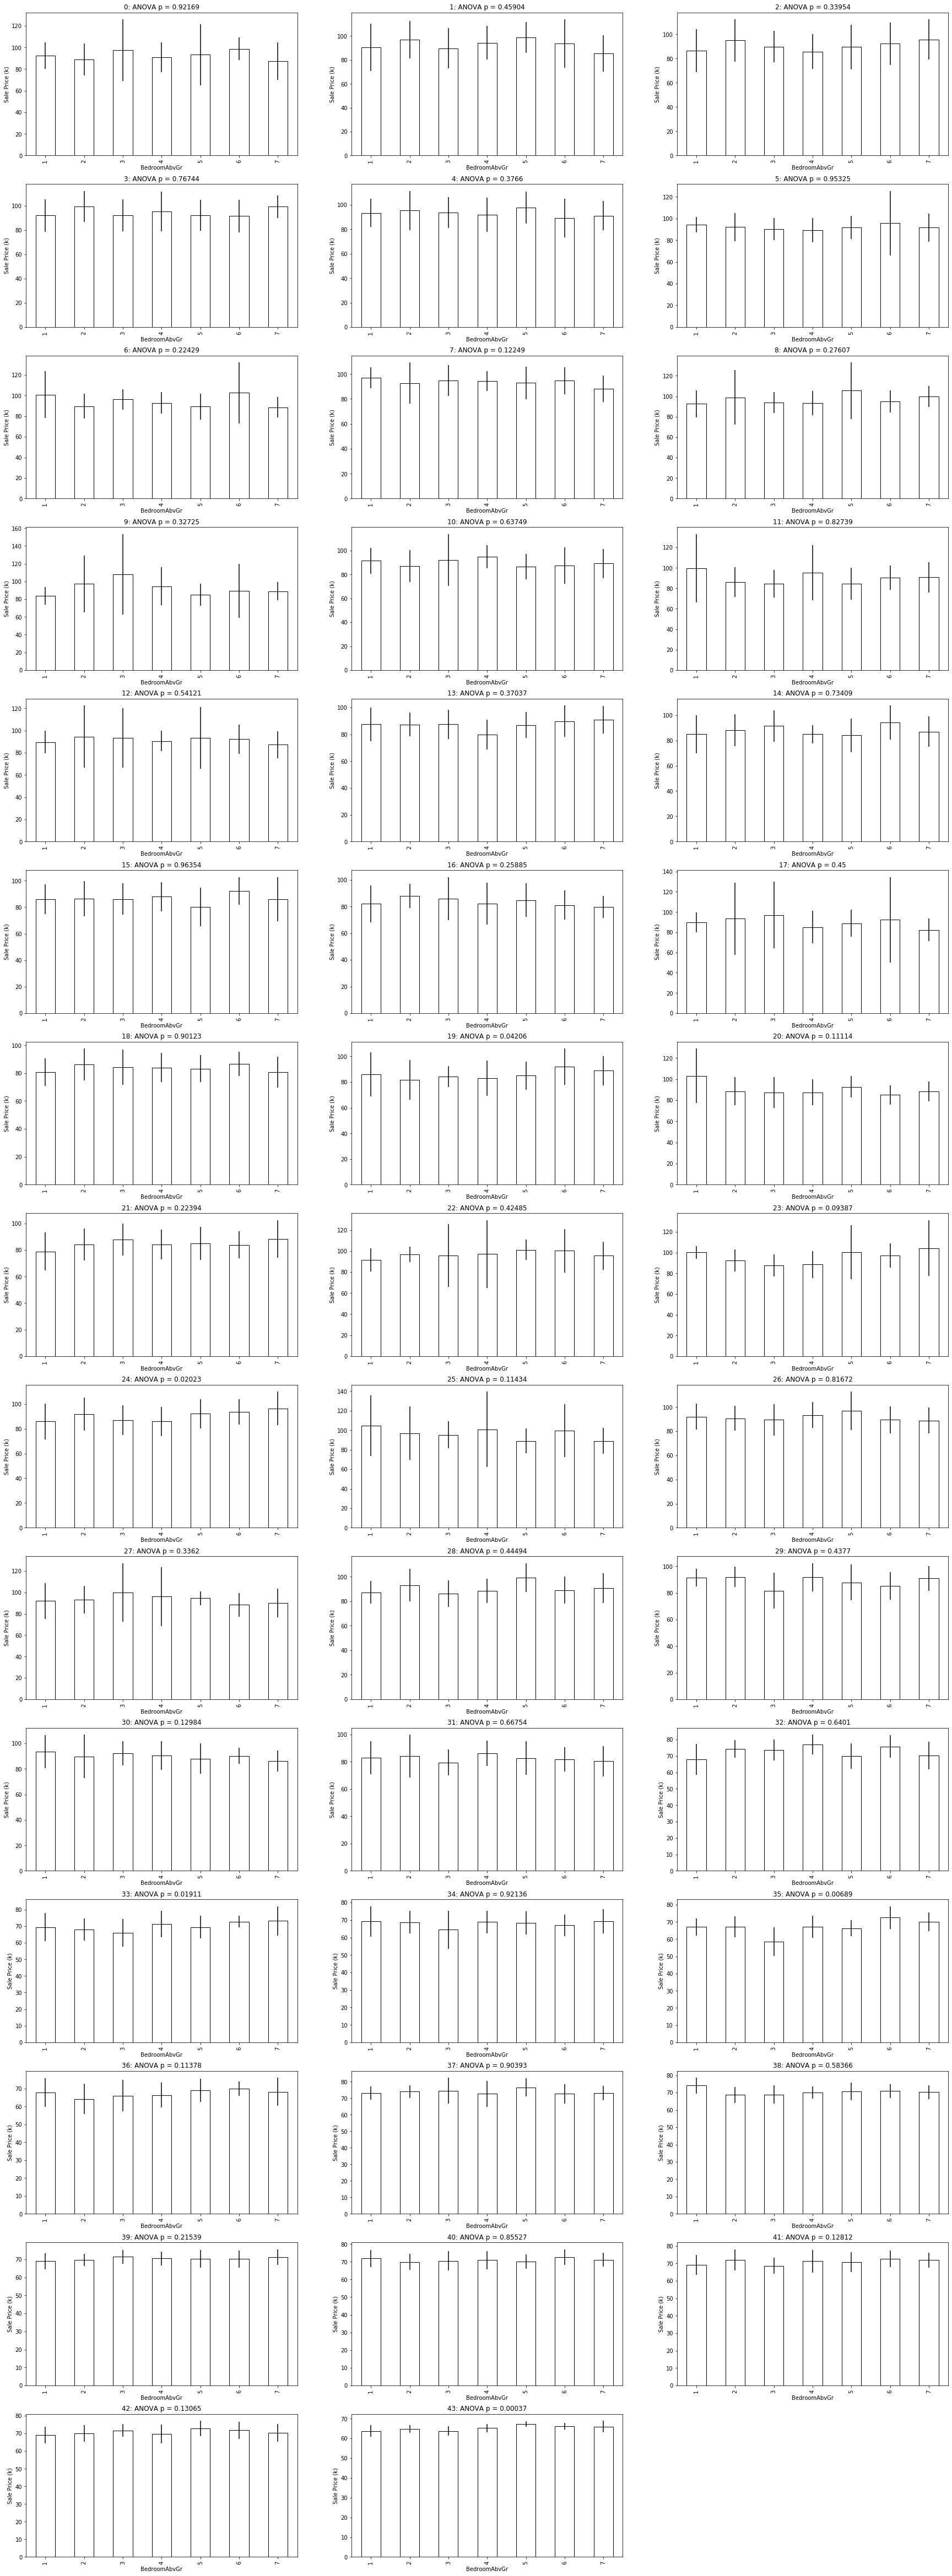

In [34]:
fig4 = plt.figure(figsize=(30,85))
for i in range(len(cols)):
    print(i)
    df_s = df1.sample(100,replace=True)
    df_new = simulate_bedroom_cols(df_s,cols[i:])# dilimit features from less important to more
    df_new2 = simulation_price(model,df_new)
    
    #Add ANOVA analysis
    new_stats = ols('SalePrice ~ BedroomAbvGr', data=df_new).fit()
    aov = sm.stats.anova_lm(new_stats, typ=2)
    name = str(i)+': ANOVA p = '+str(round(aov['PR(>F)']['BedroomAbvGr'],5) )
    
    #plot mean
    ax = fig4.add_subplot(15,3,i+1)
    plot_mean_sd_BR_2(df_new2,name)


1
50 2620
2
158 1795
3
199 1786
4
127 2624
5
332 1920


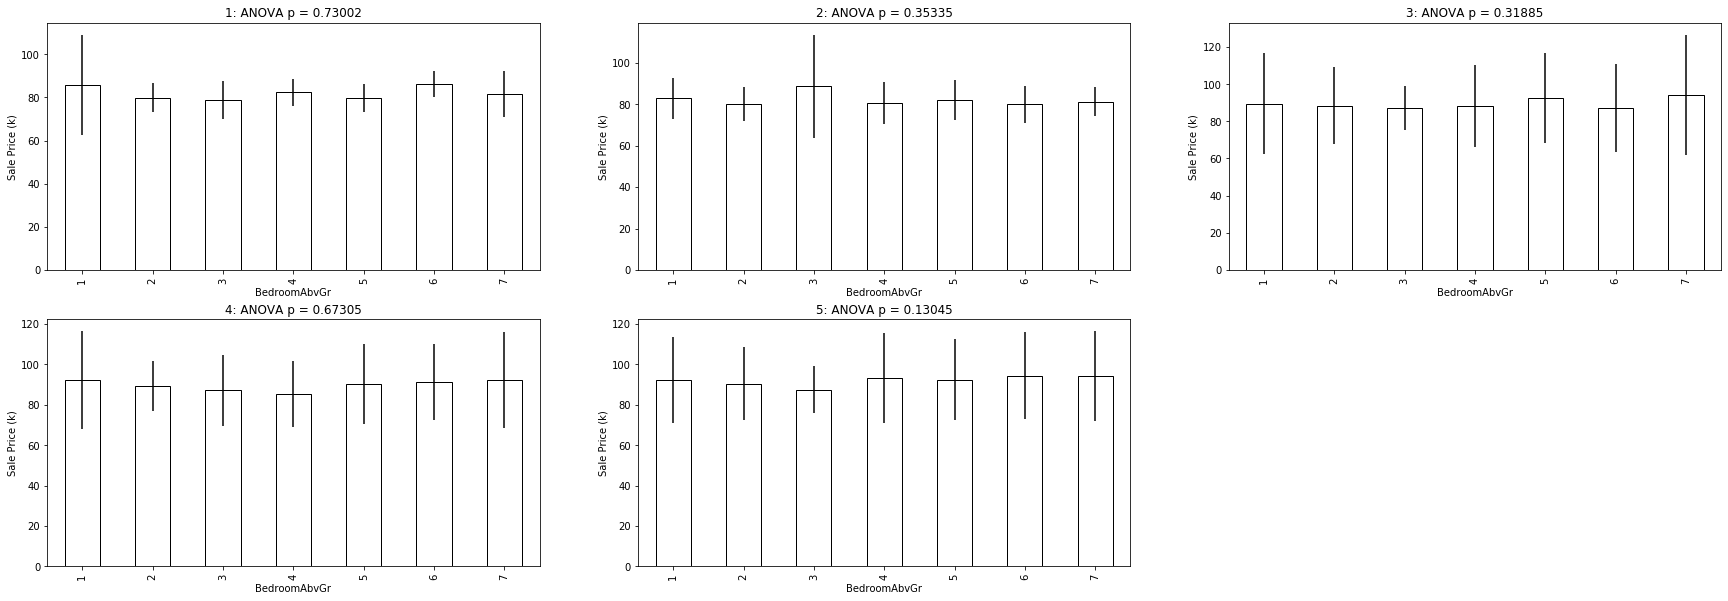

In [35]:
fig5 = plt.figure(figsize=(30,10))
for i in range(1,6):
    print(i)
    df_s = df1.sample(100*i,replace=True)
    df_new = simulate_bedroom_cols(df_s,cols[2:32])
    df_new2 = simulation_price(model,df_new)
    
    #Add ANOVA analysis
    new_stats = ols('SalePrice ~ BedroomAbvGr', data=df_new2).fit()
    aov = sm.stats.anova_lm(new_stats, typ=2)
    name = str(i)+': ANOVA p = '+str(round(aov['PR(>F)']['BedroomAbvGr'],5) )
    
    #plot mean
    ax = fig5.add_subplot(2,3,i)
    plot_mean_sd_BR_2(df_new2,name)


In [12]:
# only change bedroom number and with others not altered:

def simulate_bedroom_only(df_s):
    n = df_s.shape[0]


    df_s['BedroomAbvGr'] = [np.random.randint(1,8) for i in range(n)] # randomize bedroom numbers

    # add one more criteria to make random bedroom number more realistic
    for i in range(n):
        if df_s.iloc[i]['BedroomAbvGr'] > df_s.iloc[i]['GrLivArea']/300:
            df_s.iloc[i]['BedroomAbvGr']=int(df_s.iloc[i]['GrLivArea']/300)
    
    return df_s

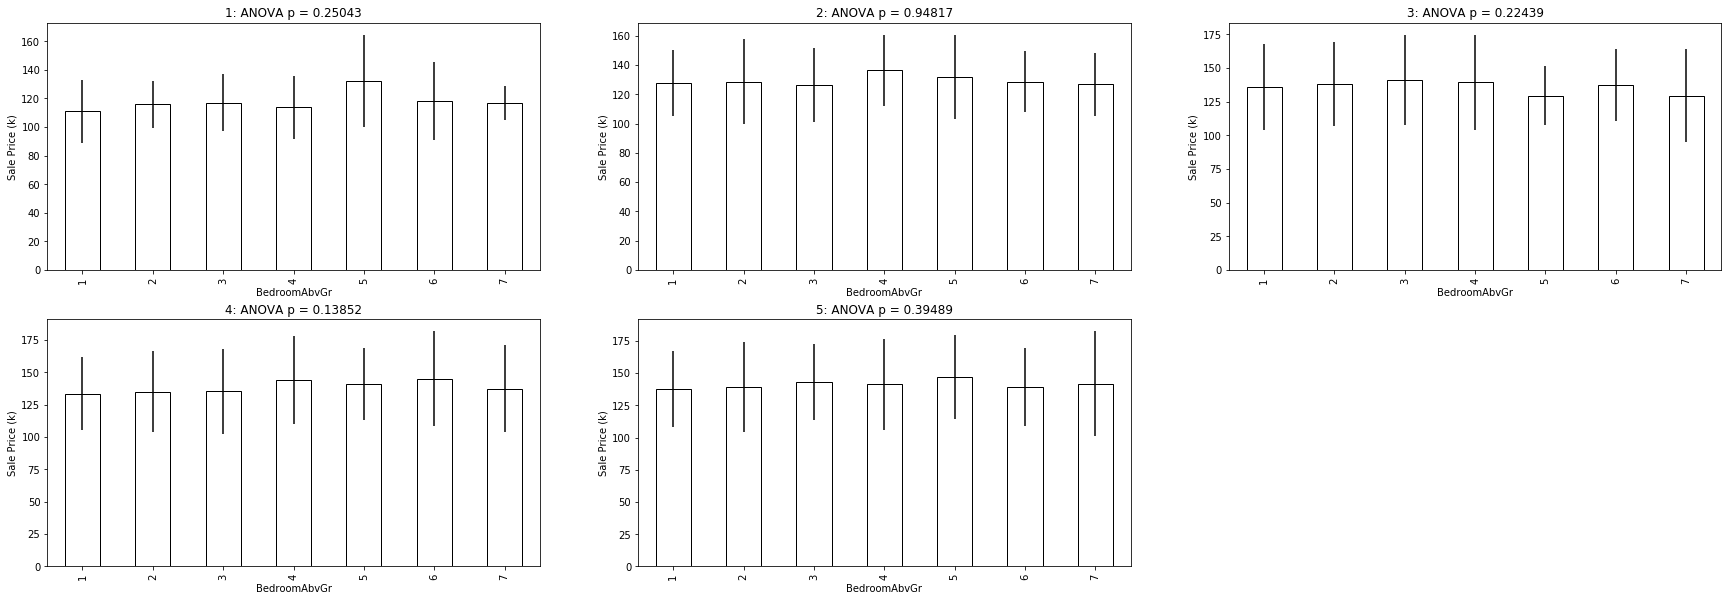

In [17]:
#-----------------------------------------------------------------------------#
# Another way to test the hypothesis:
    # Instead of making everything else the same with one random house
    # We keep everything else as in original data
    # But assign a random bedroom number (within reasonable range) to house
#-----------------------------------------------------------------------------#


fig6 = plt.figure(figsize=(30,10))
df1=df1500.drop('SalePrice',axis=1)
for i in range(1,6):
    df_new = simulate_bedroom_only(df1[:100*i])
    df_new2 = simulation_price(model,df_new)
    
    #Add ANOVA analysis
    new_stats = ols('SalePrice ~ BedroomAbvGr', data=df_new2).fit()
    aov = sm.stats.anova_lm(new_stats, typ=2)
    name = str(i)+': ANOVA p = '+str(round(aov['PR(>F)']['BedroomAbvGr'],5) )
    
    #plot mean
    ax = fig6.add_subplot(2,3,i)
    plot_mean_sd_BR_2(df_new2,name)

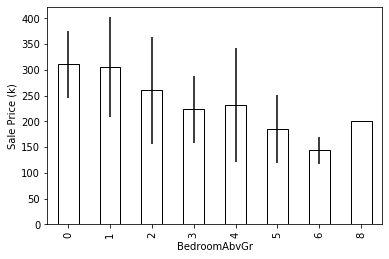

In [18]:
# Remind the original distribution and mean value
plot_mean_sd_BR(df1500)

# The Conclusion:

## The ‘bedroom number’ is negatively associated with ‘Sale Price’ in the data but not causally correlated. 

# Insights:

## Even though we saw a negative correlation in the original data sets between bedroom number and Sale Price, after simulation experimenting, we found, this correlation is not a cause but an association, and bedroom number is actually one of the least considered features to affect house price.

## This study is one example to show that we should be careful to avoid miss interpreting association with causation.